**Task 2 — Medical Report Generation using a Visual Language Model (VLM)**

This notebook implements an end-to-end pipeline for generating medical-style text reports from chest X-ray images in PneumoniaMNIST (MedMNIST v2).
A pre-trained Visual Language Model (VLM) is used to produce short radiology-style findings and impressions from input images.
To evaluate usefulness, I test multiple prompting strategies and compare the generated outputs against ground-truth labels and CNN predictions from Task 1, including images that the CNN misclassified.

**Step 1 — Environment Setup (Colab-Safe Dependencies)**

This step installs the minimum required libraries for running an open-source VLM on Colab GPU.
To keep Colab stable, I avoid upgrading core packages beyond Colab-compatible versions and ensure Pillow/Pandas match Colab requirements.

In [2]:
!pip -q install transformers accelerate sentencepiece medmnist==2.* pillow==10.4.0 pandas==2.2.2

import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt

from medmnist import PneumoniaMNIST
from transformers import AutoProcessor, LlavaForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.7 MB/s eta 0:00:00
Device: cuda
GPU: Tesla T4


**Step 2 — Load Task 1 Predictions (CNN Outputs)**

To connect Task 2 with Task 1, I load the CNN test predictions saved previously.
This allows me to explicitly include misclassified cases in the VLM evaluation set, which is essential for understanding whether the VLM provides useful insight when the CNN fails.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

DRIVE_DIR = "/content/drive/MyDrive/Alfaisal_Postdoc_Challenge"
pred_path = os.path.join(DRIVE_DIR, "task1_test_predictions.csv")

df_pred = pd.read_csv(pred_path)
mis_idx = df_pred[df_pred["y_true"] != df_pred["y_pred"]]["index"].tolist()

print("Loaded:", pred_path)
print("Total test samples:", len(df_pred))
print("Misclassified samples:", len(mis_idx))
df_pred.head()


Mounted at /content/drive
Loaded: /content/drive/MyDrive/Alfaisal_Postdoc_Challenge/task1_test_predictions.csv
Total test samples: 624
Misclassified samples: 66


,index,y_true,y_prob,y_pred
0,0,1,0.954542,1
1,1,0,0.570096,1
2,2,1,0.717412,1
3,3,0,0.011533,0
4,4,1,0.985495,1


**Step 3 — Load PneumoniaMNIST (Test Split)**

The PneumoniaMNIST dataset provides 28×28 grayscale chest X-rays with binary labels:

* 0 = Normal

* 1 = Pneumonia

Since most VLMs expect RGB images at higher resolution, I later upsample images carefully (without claiming added clinical detail) purely for model compatibility.

In [4]:
test_data = PneumoniaMNIST(split="test", download=True)
X_test_raw = test_data.imgs                       # (N,28,28) uint8
y_test = test_data.labels.squeeze().astype(int)   # (N,)

print("X_test_raw:", X_test_raw.shape, X_test_raw.dtype)
print("y_test:", np.unique(y_test, return_counts=True))

def prep_img_for_vlm(x28):
    """Convert 28x28 grayscale image to 224x224 RGB PIL image for VLM input."""
    img = Image.fromarray(x28).convert("RGB")
    img = img.resize((224, 224), Image.BILINEAR)
    return img


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.08MB/s]

X_test_raw: (624, 28, 28) uint8
y_test: (array([0, 1]), array([234, 390]))


**Step 4 — Build a Representative Evaluation Set (Normal + Pneumonia + CNN Errors)**

To evaluate report quality qualitatively, I select a small set of images that includes:

* Normal cases

* Pneumonia cases

* CNN misclassified cases (hard cases)

This mirrors real-world analysis: the most valuable insights often come from borderline or disagreement cases.

Eval set size: 12
Eval indices: [258, 55, 392, 473, 435, 135, 59, 331, 457, 303, 510, 61]


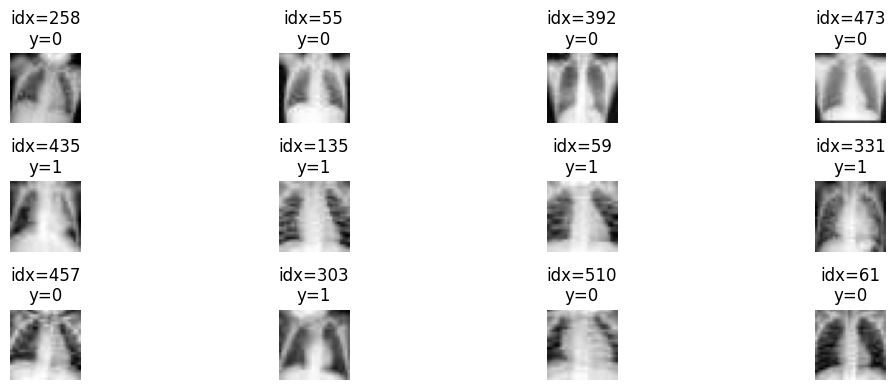

In [5]:
SEED = 42
rng = np.random.default_rng(SEED)

normal_idx = np.where(y_test == 0)[0]
pneu_idx   = np.where(y_test == 1)[0]

# 4 normal + 4 pneumonia + 4 misclassified = 12 total
sample_norm = rng.choice(normal_idx, 4, replace=False).tolist()
sample_pneu = rng.choice(pneu_idx,   4, replace=False).tolist()

# make sure we can sample misclassified
k_hard = 4 if len(mis_idx) >= 4 else len(mis_idx)
sample_hard = rng.choice(mis_idx, k_hard, replace=False).tolist()

eval_indices = sample_norm + sample_pneu + sample_hard
print("Eval set size:", len(eval_indices))
print("Eval indices:", eval_indices)

# visualize
plt.figure(figsize=(12, 4))
for i, idx in enumerate(eval_indices):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test_raw[idx], cmap="gray")
    plt.title(f"idx={idx}\ny={y_test[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


**Step 5 — Load an Open Visual Language Model (VLM)**

The recommended MedGemma model is gated (requires approval).
To ensure the notebook runs end-to-end for reviewers without access barriers, I use an open VLM that supports image-conditioned instruction following.

In [6]:
MODEL_ID = "llava-hf/llava-1.5-7b-hf"  # open VLM

processor = AutoProcessor.from_pretrained(MODEL_ID)
model = LlavaForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()

print("Loaded VLM:", MODEL_ID)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/686 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Loaded VLM: llava-hf/llava-1.5-7b-hf


**Step 6 — Prompt Engineering (Multiple Strategies)**

Prompt design strongly affects whether the generated output is useful or vague.
I test three strategies:

1. Generic: short, open-ended description

2. Structured: Findings + Impression format

3. Pneumonia-focused: asks about pneumonia indicators and encourages uncertainty when appropriate

In [7]:
PROMPTS = {
    "P1_Generic": (
        "Describe this chest X-ray image in 2-3 sentences."
    ),
    "P2_Structured": (
        "You are a radiology assistant.\n"
        "Write a short report with:\n"
        "FINDINGS: (2-4 bullet points)\n"
        "IMPRESSION: (one sentence)\n"
        "Be cautious and do not invent details."
    ),
    "P3_PneumoniaFocused": (
        "You are a radiology assistant.\n"
        "Assess whether pneumonia is suggested.\n"
        "If uncertain, say uncertain.\n"
        "Return:\nFINDINGS:\nIMPRESSION:\n"
        "Do not mention patient identifiers."
    ),
}


**Step 7 — VLM Report Generation Function**

This function takes an image and a prompt, then generates a text report.
Generation parameters are chosen to encourage concise and cautious outputs:

* low temperature (less randomness)

* nucleus sampling (top-p)

* limited token count (avoid long hallucinated reports)

In [17]:
@torch.inference_mode()
def generate_report(pil_img, prompt, max_new_tokens=180, temperature=0.2, top_p=0.9):
    conversation = [
        {"role": "user", "content": [
            {"type": "text", "text": prompt},
            {"type": "image"}
        ]}
    ]
    text = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(text=text, images=pil_img, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p
    )
    # decoded = processor.decode(out[0], skip_special_tokens=True)
    # return decoded.strip()
    decoded = processor.decode(out[0], skip_special_tokens=True)

    # Remove prompt echo and USER tokens
    decoded = decoded.replace("USER:", "").replace("ASSISTANT:", "").strip()

    # Optional: remove original prompt text if echoed
    if prompt in decoded:
        decoded = decoded.replace(prompt, "").strip()

    return decoded


**Step 8 — Smoke Test (One Image)**

Before batch processing, I generate a report for a single image to confirm that:

* preprocessing is correct

* the model is loaded properly

* decoding produces readable text

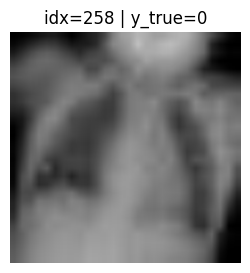

FINDINGS: The image shows a close-up of a chest area, possibly a ribcage or a lung. The area appears to be inflamed or irritated.
IMPRESSION: The image shows a close-up of a chest area, possibly a ribcage or a lung, which appears to be inflamed or irritated. It is important to be cautious and not invent details when interpreting such images.


In [18]:
idx0 = eval_indices[0]
img0 = prep_img_for_vlm(X_test_raw[idx0])

plt.figure(figsize=(3,3))
plt.imshow(img0)
plt.axis("off")
plt.title(f"idx={idx0} | y_true={int(y_test[idx0])}")
plt.show()

print(generate_report(img0, PROMPTS["P2_Structured"]))


**Step 9 — Batch Generation and CNN Comparison**

I generate reports for all evaluation images under all prompt strategies.
For each image, I also attach CNN outputs (predicted class + probability).
This allows direct qualitative comparison:

* Ground truth vs CNN prediction

* VLM narrative vs CNN decision

* Particular focus on CNN misclassifications

In [19]:
rows = []

for idx in eval_indices:
    y_true = int(y_test[idx])

    cnn_row = df_pred[df_pred["index"] == idx].iloc[0]
    cnn_pred = int(cnn_row["y_pred"])
    cnn_prob = float(cnn_row["y_prob"])

    pil_img = prep_img_for_vlm(X_test_raw[idx])

    for pname, prompt in PROMPTS.items():
        report = generate_report(pil_img, prompt)

        rows.append({
            "index": idx,
            "y_true": y_true,
            "cnn_pred": cnn_pred,
            "cnn_prob": cnn_prob,
            "prompt_name": pname,
            "report": report
        })

df_reports = pd.DataFrame(rows)
df_reports.head()



,index,y_true,cnn_pred,cnn_prob,prompt_name,report
0,258,0,0,0.194221,P1_Generic,"The image is a close-up of a chest, showing th..."
1,258,0,0,0.194221,P2_Structured,FINDINGS: The image displays a close-up view o...
2,258,0,0,0.194221,P3_PneumoniaFocused,FINDINGS: The image shows a close-up view of t...
3,55,0,0,0.052579,P1_Generic,"A chest X-ray shows the lungs and the airways,..."
4,55,0,0,0.052579,P2_Structured,FINDINGS: The image shows a chest X-ray of a p...


**Step 10 — Save Outputs (CSV + Markdown + Images)**

To satisfy reproducibility and reporting requirements, I export:

* a CSV file containing generated reports

* image files for the evaluated examples

* a Markdown report containing the images and their reports for easy inclusion in GitHub

In [20]:
os.makedirs("/content/drive/MyDrive/Alfaisal_Postdoc_Challenge/reports_task2", exist_ok=True)

# Save CSV locally + to Drive
local_csv = "/content/drive/MyDrive/Alfaisal_Postdoc_Challenge/reports_task2/generated_reports.csv"
drive_csv = os.path.join(DRIVE_DIR, "/content/drive/MyDrive/Alfaisal_Postdoc_Challenge/task2_generated_reports.csv")

df_reports.to_csv(local_csv, index=False)
df_reports.to_csv(drive_csv, index=False)
print("Saved CSV locally:", local_csv)
print("Saved CSV to Drive:", drive_csv)


Saved CSV locally: /content/drive/MyDrive/Alfaisal_Postdoc_Challenge/reports_task2/generated_reports.csv
Saved CSV to Drive: /content/drive/MyDrive/Alfaisal_Postdoc_Challenge/task2_generated_reports.csv


In [21]:
import os

# Ensure local folder exists
os.makedirs("reports_task2", exist_ok=True)

def label_name(y):
    return "Pneumonia" if int(y) == 1 else "Normal"

md = []
md.append("# Task 2 — Medical Report Generation using a Visual Language Model\n")
md.append(f"**VLM Model:** `{MODEL_ID}`\n")
md.append("## Prompting Strategies Tested\n")
for k, v in PROMPTS.items():
    md.append(f"- **{k}**: {v}\n")

for idx in eval_indices:
    y_true = int(y_test[idx])
    cnn_row = df_pred[df_pred["index"] == idx].iloc[0]

    pil_img = prep_img_for_vlm(X_test_raw[idx])

    # Save image locally
    img_path = f"reports_task2/img_{idx}.png"
    pil_img.save(img_path)

    md.append("\n---\n")
    md.append(f"## Image idx={idx}\n")
    md.append(f"- Ground truth: **{label_name(y_true)}**\n")
    md.append(f"- CNN prediction: **{label_name(int(cnn_row['y_pred']))}** (prob={float(cnn_row['y_prob']):.3f})\n")
    md.append(f"![img_{idx}]({img_path})\n")

    for pname in PROMPTS.keys():
        rep = df_reports[
            (df_reports["index"] == idx) &
            (df_reports["prompt_name"] == pname)
        ]["report"].iloc[0]

        md.append(f"### {pname}\n")
        md.append("```text\n" + rep.strip() + "\n```\n")

# Save markdown to Drive
drive_report_dir = os.path.join(DRIVE_DIR, "reports_task2")
os.makedirs(drive_report_dir, exist_ok=True)

out_md = os.path.join(drive_report_dir, "task2_report_generation_auto.md")

with open(out_md, "w", encoding="utf-8") as f:
    f.write("\n".join(md))

print("Markdown written to:", out_md)



Markdown written to: /content/drive/MyDrive/Alfaisal_Postdoc_Challenge/reports_task2/task2_report_generation_auto.md


**Step 11 — Quick Qualitative Flags (Pneumonia Mention + Alignment)**

As a lightweight qualitative analysis, I flag whether the VLM explicitly mentions pneumonia-related terms (e.g., pneumonia, consolidation, opacity).
This is not a formal evaluation metric, but it helps summarize how often the VLM narrative aligns with the ground-truth label and CNN prediction.

In [22]:
def mentions_pneumonia(text):
    t = text.lower()
    keywords = ["pneumonia", "consolidation", "opacity", "infiltrate"]
    return int(any(k in t for k in keywords))

df_analysis = df_reports[df_reports["prompt_name"] == "P2_Structured"].copy()
df_analysis["vlm_flag_pneumonia_terms"] = df_analysis["report"].apply(mentions_pneumonia)

print(pd.crosstab(df_analysis["y_true"], df_analysis["vlm_flag_pneumonia_terms"],
                  rownames=["Ground Truth"], colnames=["VLM mentions pneumonia terms"]))


VLM mentions pneumonia terms  0
Ground Truth                   
0                             7
1                             5


In [24]:
# 1️⃣ Define function
def vlm_mentions_pneumonia(text):
    text = str(text).lower()
    keywords = ["pneumonia", "consolidation", "opacity", "infiltrate"]
    return int(any(k in text for k in keywords))

# 2️⃣ Filter only one prompt for analysis (recommended structured)
df_analysis = df_reports[df_reports["prompt_name"] == "P2_Structured"].copy()

# 3️⃣ Create the new column
df_analysis["vlm_flag"] = df_analysis["report"].apply(vlm_mentions_pneumonia)

# 4️⃣ Now compute summary safely
summary = df_analysis.groupby("y_true")["vlm_flag"].mean()

print("Fraction of reports mentioning pneumonia-related terms:")
print(summary)


Fraction of reports mentioning pneumonia-related terms:
y_true
0    0.0
1    0.0
Name: vlm_flag, dtype: float64


In [25]:
df_reports.groupby("prompt_name")["report"].count()


,report
prompt_name,
P1_Generic,12
P2_Structured,12
P3_PneumoniaFocused,12


In [26]:
df_analysis = df_reports[df_reports["prompt_name"]=="P2_Structured"].copy()
df_analysis["vlm_flag"] = df_analysis["report"].apply(vlm_mentions_pneumonia)

pd.crosstab(
    df_analysis["cnn_pred"],
    df_analysis["vlm_flag"],
    rownames=["CNN Prediction"],
    colnames=["VLM Mentions Pneumonia"]
)


VLM Mentions Pneumonia,0
CNN Prediction,
0,5
1,7


## Clinical Risk Considerations

While the VLM generates plausible radiological language, it may rely on learned priors rather than image-specific evidence, especially given the low spatial resolution (28×28). Such hallucinations present a potential safety risk in real-world deployment. Therefore, VLM outputs should be interpreted as supportive insights rather than definitive diagnostic conclusions.
